# Quantum CNN

- Since quantum models can only do binary classification, we modify the MNIST dataset, in order to train the model. We create a "conv-pool-conv-pool-conv-pool" (similar to LeNet) model, which extracts the features necessary to train the model. The official tutorial from Qiskit can be viewed [here](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html).

### Workflow for QCNN

- One of the major disadvantages of current (quantum) models is that they can only accept a small number of qubits (inputs). That said, it is physically impossible to train on QCNN using actual images. A pretty simple workaround for this problem is to use an autoencoder to reduce the dimensionality of the image, so that it can be passed to the model. This is exactly what we did and it worked pretty well. We used a simple autoencoder, which enabled us to project the 28x28 images down to a vector of only 8 values, which were then fed to the model. From here, we were able to train the model and test its accuracy.

The pipeline is as follows:

$$
image \rightarrow autoencoder \rightarrow QCNN
$$


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim  # used for optimization libraries (SGD, Adam, etc)
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # used for progress bars
import matplotlib.pyplot as plt

from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

algorithm_globals.random_seed = 17
torch.manual_seed(17)  # computers a (pseudo) random, so specifying a seed allows for reproducibility
None

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
nb_channels = 16
embedding_dim = 10
batch_size = 64
nb_epochs = 50

In [3]:
# Utils


def plot_imgs(input, output):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(input, cmap="gray")
    ax[0].set_title("Input")
    ax[1].imshow(output, cmap="gray")
    ax[1].set_title("Output")
    plt.show()


def get_encoded_decoded(model, input):
    z = model.encode(input)
    output = model.decode(z)
    return z, output


def train_autoencoder(model, train_loader, optimizer, nb_epochs):
    for epoch in range(nb_epochs):
        acc_loss = 0
        for batch_idx, data in enumerate(tqdm(train_loader)):
            # send the data to cuda, if possible
            data = data.to(DEVICE)
            output = model(data)
            loss = 0.5 * (output - data).pow(2).sum() / data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {acc_loss:.4f}")


def train_binary_classifier(model, data_loader, num_epochs, learning_rate):
    # Loss and Optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train the network
    print("Training...\n")
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(tqdm(data_loader)):
            # send the data to cuda, if possible
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)

            # forward prop
            scores = model(data)
            loss = criterion(scores, targets.to(torch.float32).unsqueeze(1))

            # backward prop
            optimizer.zero_grad()  # MAKE SURE TO RESET THE GRADIENTS
            loss.backward()

            # Optimizer step
            optimizer.step()

    print("Done training, thankfully!\n")


def check_accuracy(loader: DataLoader, model, train: bool = True):
    """
    Function to check the accuracy of the trained model

    :param loader: the datasets on which the model will be evaluated on
    :param model: the model that you would like to evaluate
    :return: None
    """
    if train:
        print("Checking accuracy on training data\n")
    else:
        print("Checking accuracy on test data\n")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            scores = model(x)

            predictions = torch.where(scores > 0.5, 1, 0).flatten()
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy of {float(num_correct)/float(num_samples) * 100:.2f}%")

    model.train()

In [4]:
# QCNN Utils


def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [5]:
# we need to reduce the size of the image, so instead of cropping we can use an autoencoder to reduce the dimensionality
# note: PCA is a linear autoencoder


class ChannelAttention(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16) -> None:
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.size()) == 3:
            b, c, _ = x.size()
        else:
            b, c, _, _ = x.size()
        avg_pool = self.avg_pool(x).view(b, c)
        max_pool = self.max_pool(x).view(b, c)
        return self.sigmoid(self.fc(avg_pool) + self.fc(max_pool)).view(b, c, 1, 1)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7) -> None:
        super().__init__()

        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_pool, max_pool], dim=1)
        return self.sigmoid(self.conv(x))


class CBAM(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16) -> None:
        super().__init__()

        self.channel_attn = ChannelAttention(in_channels, reduction)
        self.spatial_attn = SpatialAttention()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.channel_attn(x) * x
        x = self.spatial_attn(x) * x
        return x


# CBAM paper - https://arxiv.org/abs/1807.06521
# CBAM is a module that uses both channel and spatial attention to improve the performance of a model


class AutoEncoder(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=5),  # to 24x24 - we are using MNIST
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),  # to 20x20
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # to 9x9
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # to 4x4
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # from 4x4
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # from 9x9
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),  # from 20x20
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),  # from 24x24
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


"""
Why put the CBAM module directly after the conv layer?
  - well, from theory, we see that the typical conv-batchnorm-relu is a good combination so it makes sense to put the CBAM module after the conv layer.
    this block (conv-batchnorm-relu) make sense, because relu clips the values so you are essnetially losing some info. we would ideally want to learn
    what to pay "attention" to before we clip the values. that said, we're also swapping relu for gelu because it has been shown to perform better (it does in this). 
"""


class AutoEncoderCBAM(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=5),  # to 24x24 - we are using MNIST
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),  # to 20x20
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # to 9x9
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # to 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # from 4x4
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # from 9x9
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),  # from 20x20
            CBAM(nb_channels, 1),
            nn.GELU(),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),  # from 24x24
        )

        # print the number of parameters
        print(f"number of parameters: {(sum(p.numel() for p in self.parameters())):,}")

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
ae_train_set = datasets.MNIST("data/mnist/", train=True, download=True)
ae_train_dataset = ae_train_set.data.view(-1, 1, 28, 28).float()
mu, std = ae_train_dataset.mean(), ae_train_dataset.std()
ae_train_dataset.sub_(mu).div_(std)
ae_train_loader = DataLoader(dataset=ae_train_dataset, batch_size=batch_size, shuffle=True)

ae_test_set = datasets.MNIST("data/mnist/", train=False, download=True)
ae_test_dataset = ae_test_set.data.view(-1, 1, 28, 28).float()
ae_test_dataset.sub_(mu).div_(std)
None  # prevent it from printing the last line

In [7]:
autoencoder = AutoEncoder(nb_channels=nb_channels, embedding_dim=embedding_dim)
autoencoder = autoencoder.to(DEVICE)

number of parameters: 31,659


In [8]:
autoencoder_cbam = AutoEncoderCBAM(nb_channels=nb_channels, embedding_dim=embedding_dim)
autoencoder_cbam = autoencoder_cbam.to(DEVICE)

number of parameters: 36,539


In [9]:
get_optimizer = lambda model: optim.AdamW(model.parameters(), lr=learning_rate)
ae_optimizer = get_optimizer(autoencoder)
cbam_ae_optimizer = get_optimizer(autoencoder_cbam)

In [ ]:
train_autoencoder(autoencoder, ae_train_loader, ae_optimizer, nb_epochs)

In [ ]:
train_autoencoder(autoencoder_cbam, ae_train_loader, cbam_ae_optimizer, nb_epochs)

In [12]:
input = ae_test_dataset[56].to(DEVICE)

# Encode / decode
z, output = get_encoded_decoded(autoencoder, input)
z_cbam, output_cbam = get_encoded_decoded(autoencoder_cbam, input.unsqueeze(0))

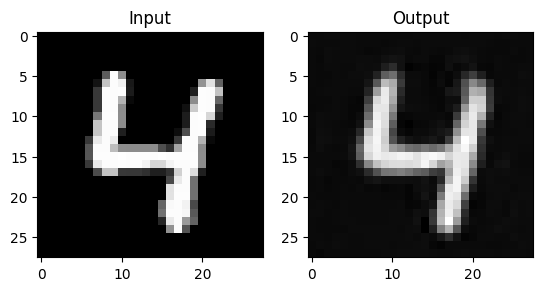

In [13]:
plot_imgs(input.cpu().detach().numpy().squeeze(), output.cpu().detach().numpy().squeeze())

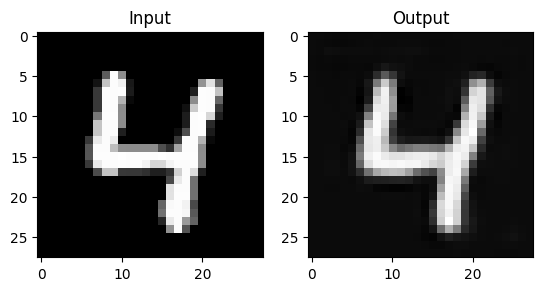

In [14]:
plot_imgs(input.cpu().detach().numpy().squeeze(), output_cbam.cpu().detach().numpy().squeeze())

In [19]:
def get_qcnn_circuit(num_qubits: int = 8) -> tuple[QuantumCircuit, EstimatorQNN]:
    assert num_qubits <= 12, "We need to set an artificial limit on the number of qubits, so choose a value <= 12"
    feature_map = ZFeatureMap(feature_dimension=num_qubits)
    ansatz = QuantumCircuit(num_qubits, name="ansatz")

    ansatz.compose(conv_layer(num_qubits=num_qubits, param_prefix="c1"), qubits=list(range(num_qubits)), inplace=True)
    ansatz.compose(
        pool_layer(
            sources=list(range(num_qubits // 2)), sinks=list(range(num_qubits // 2, num_qubits)), param_prefix="p1"
        ),
        qubits=list(range(num_qubits)),
        inplace=True,
    )

    ansatz.compose(
        conv_layer(num_qubits=num_qubits // 2, param_prefix="c2"),
        qubits=list(range(num_qubits // 2, num_qubits)),
        inplace=True,
    )
    ansatz.compose(
        pool_layer(
            sources=list(range(num_qubits // 4)), sinks=list(range(num_qubits // 4, num_qubits // 2)), param_prefix="p2"
        ),
        qubits=list(range(num_qubits // 2, num_qubits)),
        inplace=True,
    )

    ansatz.compose(
        conv_layer(num_qubits=num_qubits // 4, param_prefix="c3"),
        qubits=list(range(num_qubits - (num_qubits // 4), num_qubits)),
        inplace=True,
    )
    ansatz.compose(
        pool_layer(sources=list(range(2)), sinks=list(range(2, num_qubits // 4)), param_prefix="p3"),
        qubits=list(range(num_qubits - (num_qubits // 4), num_qubits)),
        inplace=True,
    )

    # Combining the feature map and ansatz
    circuit = QuantumCircuit(num_qubits)
    circuit.compose(feature_map, range(num_qubits), inplace=True)
    circuit.compose(ansatz, range(num_qubits), inplace=True)

    observable = SparsePauliOp.from_list([("Z" + "I" * (num_qubits - 1), 1)])

    # we decompose the circuit for the QNN to avoid additional data copying
    qnn = EstimatorQNN(
        circuit=circuit.decompose(),
        observables=observable,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
    )

    return circuit, qnn

In [20]:
circuit, qcnn = get_qcnn_circuit(num_qubits=embedding_dim)

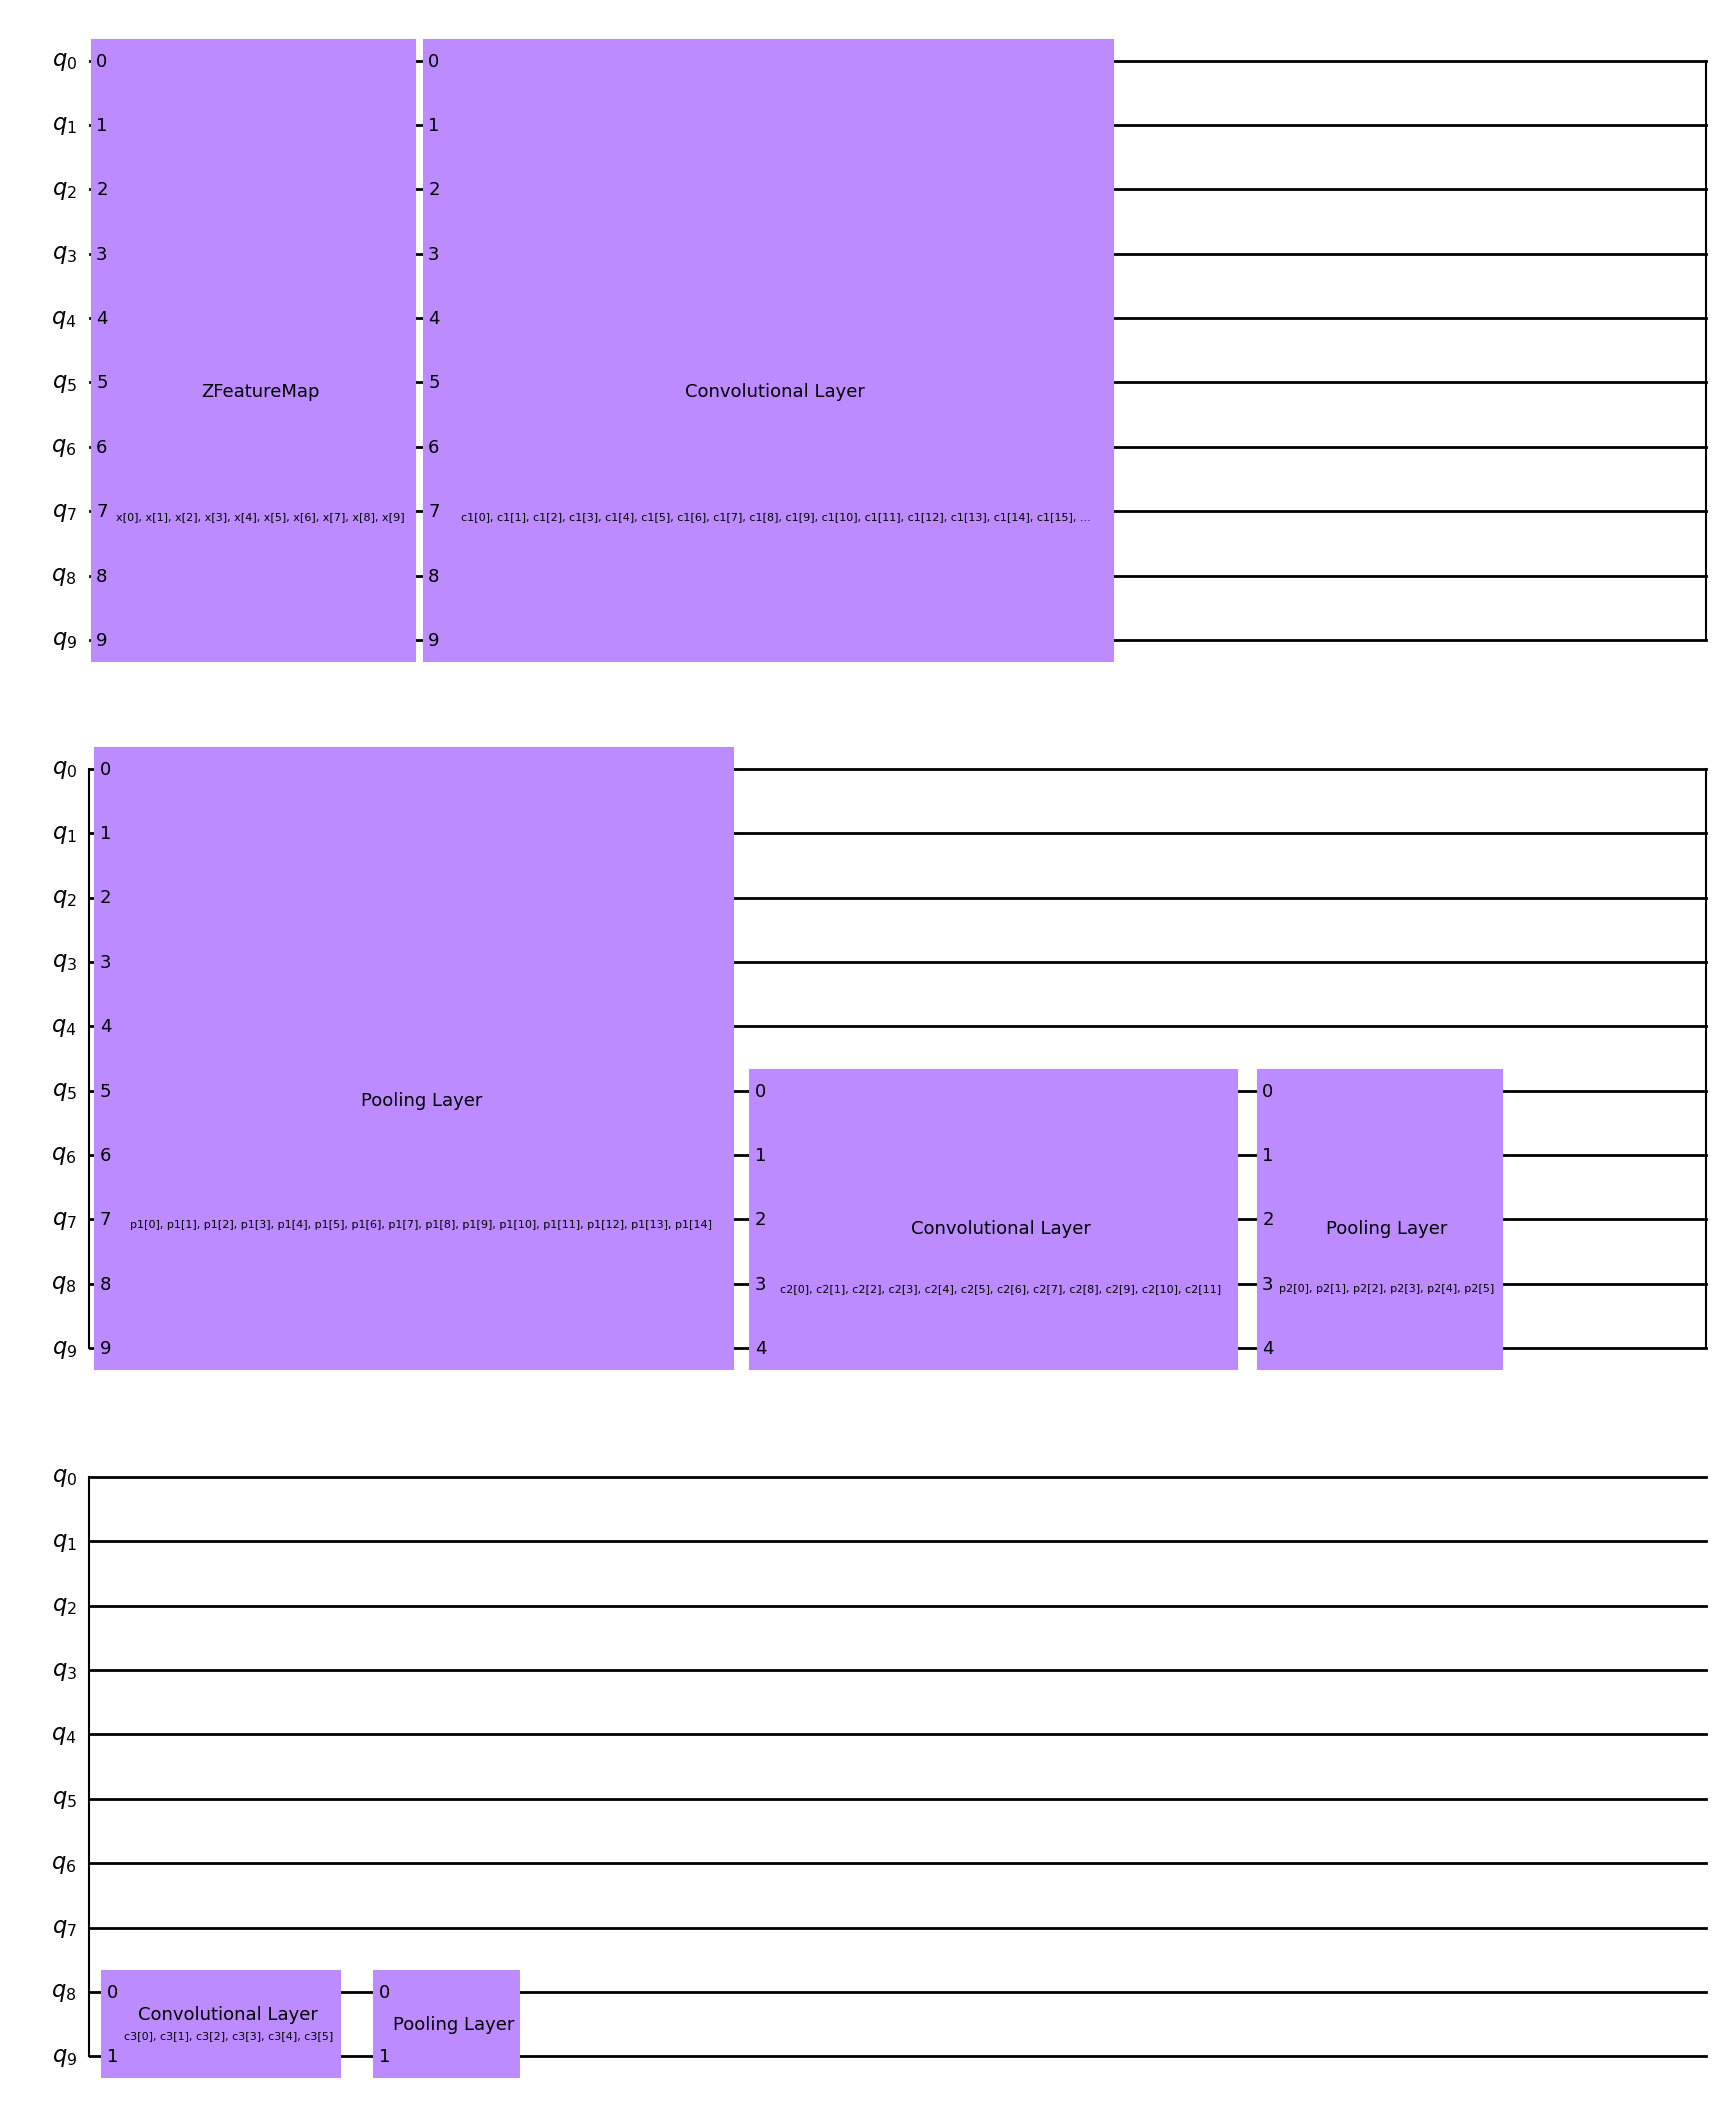

In [21]:
circuit.draw("mpl", style="clifford")

In [22]:
# Takes too long to train QCNN

qcnn_train_set = datasets.MNIST("data/mnist/", train=True, transform=transforms.ToTensor(), download=True)
qcnn_test_set = datasets.MNIST("data/mnist/", train=False, transform=transforms.ToTensor(), download=True)

X_train, X_test, y_train, y_test = (
    qcnn_train_set.data,
    qcnn_test_set.data,
    qcnn_train_set.targets,
    qcnn_test_set.targets,
)


def prep_dataset(X, y, filter_vals, dataset_size):
    X = X.unsqueeze(1).reshape(-1, 1, 28, 28).to(torch.float32)
    X_filtered = np.concatenate((X[filter_vals[0]][: dataset_size // 2], X[filter_vals[1]][: dataset_size // 2]))
    y_filtered = np.concatenate((y[filter_vals[0]][: dataset_size // 2], y[filter_vals[1]][: dataset_size // 2]))
    return X_filtered, y_filtered


def change_labels(labels, set_1, set_2, set_1_val, set_2_val):
    labels[labels == set_1] = set_1_val
    labels[labels == set_2] = set_2_val
    return labels


N = 100
set_1 = 3
set_1_vals_train = np.where(y_train == set_1)[0]
set_1_vals_test = np.where(y_test == set_1)[0]
set_2 = 6
set_2_vals_train = np.where(y_train == set_2)[0]
set_2_vals_test = np.where(y_test == set_2)[0]

encode = lambda x: autoencoder_cbam.encode(x.to(DEVICE)).detach().cpu().numpy()

X_train, y_train = prep_dataset(X_train, y_train, [set_1_vals_train, set_2_vals_train], N)
X_test, y_test = prep_dataset(X_test, y_test, [set_1_vals_test, set_2_vals_test], N)


X_train_encoded = encode(torch.Tensor(X_train))
X_test_encoded = encode(torch.Tensor(X_test))

X_train_encoded, y_train = shuffle(X_train_encoded, y_train, random_state=17)
X_test_encoded, y_test = shuffle(X_test_encoded, y_test, random_state=17)


# labels/targets need to be 1 and -1
y_train = change_labels(y_train, set_1, set_2, -1, 1)
y_test = change_labels(y_test, set_1, set_2, -1, 1)

In [23]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [24]:
classifier = NeuralNetworkClassifier(
    qcnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

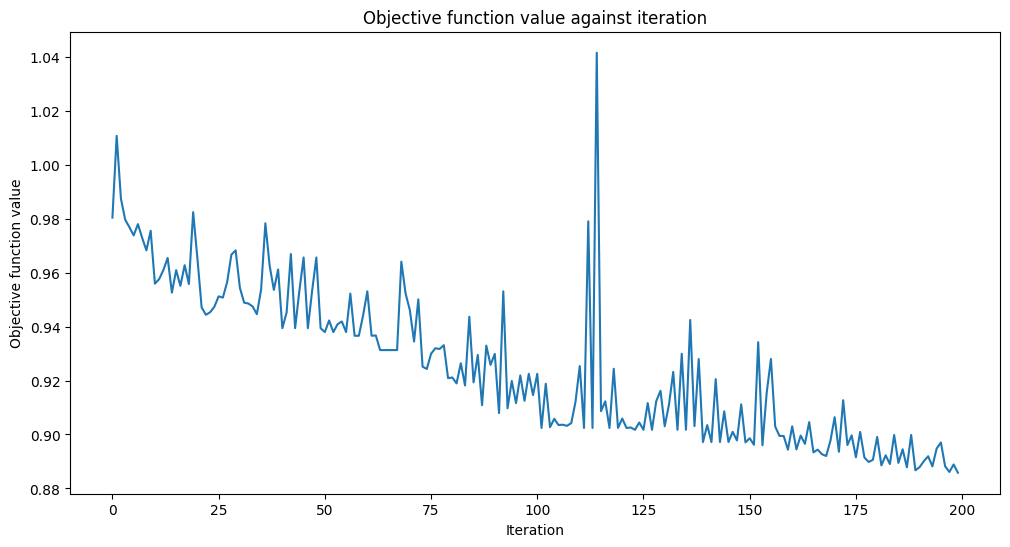

In [25]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
x = np.asarray(X_train_encoded)
y = np.asarray(y_train)
classifier.fit(x, y)

In [ ]:
x = np.asarray(X_test_encoded)
y = np.asarray(y_test)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 45.0%


In [ ]:
# for binary classfication, we need the labels to be either 0 or 1
y_train = change_labels(y_train, 1, -1, 1, 0)
y_test = change_labels(y_test, 1, -1, 1, 0)

In [ ]:
class LeNet(nn.Module):
    """
    LeNet paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
    """

    def __init__(self, num_classes: int = 2):
        super(LeNet, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(2, 2),
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return self.sigmoid(x)

In [ ]:
def get_dataloaders(X_train, X_test, y_train, y_test, batch_size: int = 64):
    train_loader = DataLoader(
        [(X_train[i], y_train[i]) for i in range(len(X_train))], batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader([(X_test[i], y_test[i]) for i in range(len(X_test))], batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
train_loader, test_loader = get_dataloaders(X_train, X_test, y_train, y_test)

In [ ]:
# Hyper-parameters
num_classes = 1
learning_rate = 1e-3
batch_size = 64
num_epochs = 50


# init network
model = LeNet(num_classes=num_classes)
model = model.to(DEVICE)

In [ ]:
train_binary_classifier(model, train_loader, num_epochs, learning_rate)

In [ ]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model, False)

Checking accuracy on training data



100%|██████████| 2/2 [00:00<00:00, 653.88it/s]


Got 100 / 100 with accuracy of 100.00%
Checking accuracy on test data



100%|██████████| 2/2 [00:00<00:00, 506.10it/s]

Got 53 / 100 with accuracy of 53.00%


We can see that the classical model performed better, while less than 400x the time to train. This is sort of disingenious, because we trained this network with an entire image, whereas the QCNN used an encode version of the image, which only has 8=10 values. That said, let's train a network that is more comparable to that.


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [ ]:
mlp = MLP(embedding_dim, 32, 1)
mlp = mlp.to(DEVICE)

In [115]:
encoded_train_loader, encoded_test_loader = get_dataloaders(X_train_encoded, X_test_encoded, y_train, y_test)

In [ ]:
train_binary_classifier(mlp, encoded_train_loader, num_epochs, learning_rate)

In [118]:
check_accuracy(encoded_train_loader, mlp)
check_accuracy(encoded_test_loader, mlp, False)

Checking accuracy on training data



100%|██████████| 2/2 [00:00<00:00, 533.39it/s]


Got 97 / 100 with accuracy of 97.00%
Checking accuracy on test data



100%|██████████| 2/2 [00:00<00:00, 719.50it/s]

Got 87 / 100 with accuracy of 87.00%


Here, we get even better results (which is to be expected). We can see that a QCNN is not suited for a binary classification task.
